## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# 라이브러리 버전 확인
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.1.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
alembic                       1.8.1
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
ansi2html                     1.8.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopage                      0.5.1
autopep8                      1.6.0
awscli                        1.25.90
azu

## Hyperparameter setting

In [2]:
CFG = {
    'EPOCHS': 30,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## Data Load

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

## Data Preprocessing

In [5]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']
# Inference(실제 진단 환경)에 사용하는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

### 1. 결측치 처리

In [7]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

### 2. Train / Validation Split

In [8]:
all_X = train.drop(['ID', 'Y_LABEL'], axis = 1)
all_y = train['Y_LABEL']

test = test.drop(['ID'], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(all_X, all_y, test_size=0.2, random_state=CFG['SEED'], stratify=all_y)

###  3. Data label-encoding, scaling

In [10]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        val_X[col] = scaler.transform(get_values(val_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))
            
le = LabelEncoder()
for col in categorical_features:    
    train_X[col] = le.fit_transform(train_X[col])
    val_X[col] = le.transform(val_X[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

## CustomDataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data_X, data_y, distillation=False):
        super(CustomDataset, self).__init__()
        self.data_X = data_X
        self.data_y = data_y
        self.distillation = distillation
        
    def __len__(self):
        return len(self.data_X)
    
    def __getitem__(self, index):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.Tensor(self.data_X.iloc[index])
            student_X = torch.Tensor(self.data_X[test_stage_features].iloc[index])
            y = self.data_y.values[index]
            return teacher_X, student_X, y
        else:
            if self.data_y is None:
                test_X = torch.Tensor(self.data_X.iloc[index])
                return test_X
            else:
                teacher_X = torch.Tensor(self.data_X.iloc[index])
                y = self.data_y.values[index]
                return teacher_X, y

In [15]:
train_dataset = CustomDataset(train_X, train_y, False)
val_dataset = CustomDataset(val_X, val_y, False)

In [16]:
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False)

## Define Teacher Model

In [17]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=52, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.classifier(x)
        return output

## Teacher Train / Validation

In [18]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)

    best_score = 0
    best_model = None
    criterion = nn.BCELoss().to(device)

    for epoch in range(CFG["EPOCHS"]):
        train_loss = []
  
        model.train()
        for X, y in tqdm(train_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X)
            
            loss = criterion(y_pred, y.reshape(-1, 1))
            loss.backward()
            
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation_teacher(model, val_loader, criterion, device)
        print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model 

In [19]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation_teacher(model, val_loader, criterion, device):
    model.eval()

    val_loss = []
    pred_labels = []
    true_labels = []
    threshold = 0.35
    
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X = X.float().to(device)
            y = y.float().to(device)
            
            model_pred = model(X.to(device))
            
            loss = criterion(model_pred, y.reshape(-1, 1))
            val_loss.append(loss.item())      
            
            model_pred = model_pred.squeeze(1).to('cpu')  
            pred_labels += model_pred.tolist()
            true_labels += y.tolist()
        
        pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
        val_f1 = competition_metric(true_labels, pred_labels)
    return val_loss, val_f1   

## Run (Teacher Model)

In [20]:
model = Teacher()
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold_mode='abs',min_lr=1e-8, verbose=True)

teacher_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [0], Train Loss : [0.26386] Val Loss : [0.24666] Val F1 Score : [0.74628]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.19354] Val Loss : [0.28965] Val F1 Score : [0.77351]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.19037] Val Loss : [0.26236] Val F1 Score : [0.77839]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.19434] Val Loss : [0.32435] Val F1 Score : [0.76965]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.17337] Val Loss : [0.29550] Val F1 Score : [0.78432]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.17711] Val Loss : [0.24747] Val F1 Score : [0.78659]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.18107] Val Loss : [0.32696] Val F1 Score : [0.78712]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.16138] Val Loss : [0.28585] Val F1 Score : [0.78870]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.15253] Val Loss : [0.44411] Val F1 Score : [0.78152]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.15027] Val Loss : [0.34605] Val F1 Score : [0.76581]
Epoch 00010: reducing learning rate of group 0 to 5.0000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.16506] Val Loss : [0.24903] Val F1 Score : [0.79411]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.15035] Val Loss : [0.27683] Val F1 Score : [0.79278]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.13647] Val Loss : [0.27611] Val F1 Score : [0.79730]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.13302] Val Loss : [0.27945] Val F1 Score : [0.79065]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.12789] Val Loss : [0.31553] Val F1 Score : [0.79724]
Epoch 00015: reducing learning rate of group 0 to 2.5000e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.12381] Val Loss : [0.31837] Val F1 Score : [0.78914]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.13375] Val Loss : [0.32476] Val F1 Score : [0.79490]
Epoch 00017: reducing learning rate of group 0 to 1.2500e-03.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.11679] Val Loss : [0.30735] Val F1 Score : [0.79995]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.11213] Val Loss : [0.29264] Val F1 Score : [0.79260]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.10855] Val Loss : [0.31224] Val F1 Score : [0.78721]
Epoch 00020: reducing learning rate of group 0 to 6.2500e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.10802] Val Loss : [0.31663] Val F1 Score : [0.79520]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.10394] Val Loss : [0.32885] Val F1 Score : [0.79267]
Epoch 00022: reducing learning rate of group 0 to 3.1250e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.10969] Val Loss : [0.30202] Val F1 Score : [0.79438]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.11493] Val Loss : [0.31470] Val F1 Score : [0.79178]
Epoch 00024: reducing learning rate of group 0 to 1.5625e-04.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.10657] Val Loss : [0.32573] Val F1 Score : [0.79112]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.10137] Val Loss : [0.32656] Val F1 Score : [0.77340]
Epoch 00026: reducing learning rate of group 0 to 7.8125e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.09914] Val Loss : [0.31189] Val F1 Score : [0.79140]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.11240] Val Loss : [0.32554] Val F1 Score : [0.78277]
Epoch 00028: reducing learning rate of group 0 to 3.9063e-05.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.10139] Val Loss : [0.31501] Val F1 Score : [0.77382]


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.10229] Val Loss : [0.31947] Val F1 Score : [0.78137]
Epoch 00030: reducing learning rate of group 0 to 1.9531e-05.


# Prediction of Anomaly probability

In [22]:
for col in all_X.columns:
    if col not in categorical_features:
        scaler = StandardScaler()
        all_X[col] = scaler.fit_transform(get_values(all_X[col]))
        
le = LabelEncoder()
for col in categorical_features:    
    all_X[col] = le.fit_transform(all_X[col])

In [24]:
all_X.head()

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
0,2,-0.393763,4,-0.051413,-0.340760,-0.150214,-0.111628,0.281646,-0.238453,-0.041491,...,-5.981470e-17,-8.994821e-17,0.000000,1.070528e-16,3.033162e-16,0.000000,-0.10655,2.575229e-14,0.899892,-0.966002
1,1,-0.426022,14,3.715319,-0.022576,-0.150214,-0.123127,-0.437686,-0.238453,-0.041491,...,-3.492014e-01,-7.056401e-01,-0.696928,-8.811477e-01,-8.792207e-01,-1.154469,-0.10655,2.575229e-14,-1.317376,0.119147
2,1,-0.173409,8,-0.479451,-0.340760,-0.150214,1.118753,-0.612659,0.105735,-0.041491,...,-4.165468e-01,-7.562765e-01,-0.710314,-7.568504e-01,9.625312e-01,1.392528,-0.10655,2.575229e-14,-0.740886,-0.332215
3,2,1.006399,3,-0.479451,-0.340760,-0.150214,-0.054133,-0.593217,-0.238453,-0.041491,...,-5.981470e-17,-8.994821e-17,0.000000,1.070528e-16,3.033162e-16,0.000000,-0.10655,2.575229e-14,0.482642,-1.093888
4,2,0.191634,8,-0.308236,-0.340760,-0.150214,-0.134626,0.903771,-0.238453,-0.041491,...,-5.981470e-17,-8.994821e-17,0.000000,1.070528e-16,3.033162e-16,0.000000,-0.10655,2.575229e-14,0.478611,-0.866326


In [25]:
np_all_X = all_X.values
torch_all_X = torch.from_numpy(np_all_X).float()

In [26]:
out = teacher_model(torch_all_X)

In [27]:
out_to_np = out.detach().numpy()
out_df = pd.DataFrame(out_to_np, columns = {'prob_1'})
out_df

,prob_1
0,0.011024
1,0.000174
2,0.998913
3,0.296974
4,0.010189
...,...
14090,0.009156
14091,0.008283
14092,0.217382
14093,0.035719


# Distillation

## Define Student Model

In [29]:
student_X = all_X[test_stage_features]
student_y = out_df.copy()

In [30]:
train_student_X, val_student_X, train_student_y, val_student_y = train_test_split(student_X, student_y, test_size=0.2, random_state=42)

### LightGBM

In [31]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

lgbm_reg = LGBMRegressor(n_estimators=10000, metric= 'mae', random_state = 2022)

In [32]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'mae', 
            "eval_set" : [(val_student_X, val_student_y)],
            'verbose': 1,
            'categorical_feature': ['COMPONENT_ARBITRARY', 'YEAR']}

In [33]:
lgbm_reg.fit(train_student_X, train_student_y, **fit_params)

[1]	valid_0's l1: 0.120244
[2]	valid_0's l1: 0.11845
[3]	valid_0's l1: 0.116811
[4]	valid_0's l1: 0.115488
[5]	valid_0's l1: 0.114369
[6]	valid_0's l1: 0.113207
[7]	valid_0's l1: 0.112295
[8]	valid_0's l1: 0.111563
[9]	valid_0's l1: 0.110854
[10]	valid_0's l1: 0.110215
[11]	valid_0's l1: 0.109829
[12]	valid_0's l1: 0.109406
[13]	valid_0's l1: 0.109059
[14]	valid_0's l1: 0.108743
[15]	valid_0's l1: 0.108491
[16]	valid_0's l1: 0.108238
[17]	valid_0's l1: 0.107945
[18]	valid_0's l1: 0.107719
[19]	valid_0's l1: 0.107422
[20]	valid_0's l1: 0.107327
[21]	valid_0's l1: 0.107171
[22]	valid_0's l1: 0.10713
[23]	valid_0's l1: 0.106986
[24]	valid_0's l1: 0.106814
[25]	valid_0's l1: 0.106722
[26]	valid_0's l1: 0.10662
[27]	valid_0's l1: 0.106551
[28]	valid_0's l1: 0.106467
[29]	valid_0's l1: 0.106416
[30]	valid_0's l1: 0.106396
[31]	valid_0's l1: 0.106307
[32]	valid_0's l1: 0.106211
[33]	valid_0's l1: 0.10619
[34]	valid_0's l1: 0.106186
[35]	valid_0's l1: 0.106073
[36]	valid_0's l1: 0.106156
[37]	

LGBMRegressor(metric='mae', n_estimators=10000, random_state=2022)

In [40]:
import joblib 
joblib.dump(lgbm_reg, 'lgbm_reg.pkl')

['lgbm_reg.pkl']

# Inference

In [34]:
test_predict = lgbm_reg.predict(test)

# Submit

In [35]:
submit = pd.read_csv('./sample_submission.csv')
submit_label = np.where(np.array(test_predict) > 0.2, 1, 0)

In [36]:
submit['Y_LABEL'] = submit_label

In [37]:
submit.to_csv('submit_(1).csv', index = False)

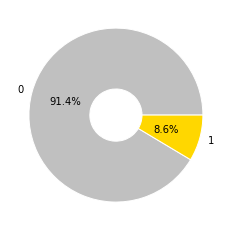

In [39]:
labels= ['0','1']
colors = ['silver', 'gold']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
plt.pie(submit['Y_LABEL'].value_counts(), labels=labels, autopct='%.1f%%', colors=colors, wedgeprops=wedgeprops)
plt.show()

# END